<center> <b>Machine Learning - SBU FALL 2024</b></center> 

[google drive link](https://drive.google.com/drive/folders/1WPygqVXIzM5VidMGBmSvVxvS4jAB-GBX)

In [1]:
student_number = '400243082'
Name = 'Pouria'
Last_Name = 'Yazdani'


# MobileNet V1: A PyTorch Tutorial



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 
- Learn the theory of depthwise separable convolutions 
- Implement and use MobileNet V1 in PyTorch


![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Subset


Check your device. We recommend using GPU. You can use GPU with google colab.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [3]:
def batch_normalization(x:np.ndarray, gamma:float, beta:float, epsilon:float=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0, keepdims=True) # maintain dims for brodcasting
    variance = np.var(x, axis=0, keepdims=True)
    
    x_normalized = (x - mean) / np.sqrt(variance + epsilon)
    
    out = gamma * x_normalized + beta
    
    return out


In [4]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [5]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])



# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

print(f"Train Dataset Size: {len(train_set)} samples")

train_indices = list(range(len(train_set) // 2))
train_set = Subset(train_set, train_indices)
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

train_images, train_labels = next(iter(train_loader))
print(f"Train Batch - Images Shape: {train_images.shape}, Labels Shape: {train_labels.shape}")
print(f"Training dataset size: {len(train_loader.dataset)}")


# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

print(f"Validation Dataset Size: {len(val_set)} samples")

# VALIDATION DATA (First 5,000 Samples)
val_indices = list(range(0, 5000))
val_set_final = Subset(val_set, val_indices)
val_loader = DataLoader(val_set_final, batch_size=64, shuffle=False)

val_images, val_labels = next(iter(val_loader))
print(f"Validation Batch - Images Shape: {val_images.shape}, Labels Shape: {val_labels.shape}")
print(f"Validation dataset size: {len(val_loader.dataset)}")


# TEST DATA (Remaining 5,000 Samples)
test_indices = list(range(5000, 10000))
test_set_final = Subset(val_set, test_indices)
test_loader = DataLoader(test_set_final, batch_size=64, shuffle=False)

test_images, test_labels = next(iter(test_loader))
print(f"Test Batch - Images Shape: {test_images.shape}, Labels Shape: {test_labels.shape}")
print(f"Test dataset size: {len(test_loader.dataset)}")

Files already downloaded and verified
Train Dataset Size: 50000 samples
Train Batch - Images Shape: torch.Size([64, 3, 224, 224]), Labels Shape: torch.Size([64])
Training dataset size: 25000
Files already downloaded and verified
Validation Dataset Size: 10000 samples
Validation Batch - Images Shape: torch.Size([64, 3, 224, 224]), Labels Shape: torch.Size([64])
Validation dataset size: 5000
Test Batch - Images Shape: torch.Size([64, 3, 224, 224]), Labels Shape: torch.Size([64])
Test dataset size: 5000


### Question

Explain what we did in transfor train and tranform test:<br/>
In our data preprocessing pipeline, we applied **different transformations** for training and testing datasets to optimize the model's performance and ensure consistency during evaluation.

### Answer
###  **1. `transform_train` (Training Transformations)**

The purpose of these transformations is **data augmentation** to make the model more **robust** and **prevent overfitting**.

####  **Transformations Applied:**

1. **`RandomResizedCrop(224, scale=(0.5, 1.0))`:**  
   - Randomly crops a portion of the image and resizes it to **224×224** pixels.  
   - The crop size varies between **50% to 100%** of the original image size.  
   - Helps the model learn features from different parts of the image.

2. **`RandomHorizontalFlip()`**:  
   - Randomly flips the image **horizontally** with a **50% probability**.  
   - Helps the model generalize better to variations in object orientation.

3. **`ToTensor()`**:  
   - Converts the image from **PIL format** to a **PyTorch tensor**.  
   - Scales pixel values from the range **[0, 255]** to **[0, 1]**. (defualt behavior)

4. **`Normalize(mean, std)`**:  
   - Ensures the model receives consistent inputs.


###  **2. `transform_test` (Testing Transformations)**

The purpose of these transformations is to **ensure consistent image dimensions** and **standardize the inputs** for evaluation.

####  **Transformations Applied:**

1. **`Resize((224, 224))`:**  
   - Resizes all images to a fixed size of **224×224** pixels.  
   - Ensures consistency across all test samples.

2. **`ToTensor()`**:  
   - Converts the image from **PIL format** to a **PyTorch tensor**.  
   - Scales pixel values to the range **[0, 1]**.

3. **`Normalize(mean, std)`**:  
   - Ensures consistent data distribution across channels.


###  **Key Differences Between Train and Test Transforms**

| **Transform**       | **Train (`transform_train`)**        | **Test (`transform_test`)**  |
|----------------------|--------------------------------------|------------------------------|
| **Resizing**        | `RandomResizedCrop(224)`             | `Resize((224, 224))`         |
| **Flipping**        | `RandomHorizontalFlip()`            | No flipping                 |
| **Normalization**   | Mean & Std applied                  | Mean & Std applied           |
| **Tensor Conversion** | Applied                            | Applied                      |

###  **Purpose Recap:**
- **Train Transform:** Data augmentation to improve generalization and robustness.  
- **Test Transform:** Ensures consistent input size and normalization for evaluation.

---


for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

In [6]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # Convert (C, H, W) → (H, W, C)
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = std * img + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip to valid range [0, 1]
    
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def plot_multiple_images(data_loader, num_ims, title):
    """
    Display a grid of num_ims images from a DataLoader.
    
    Parameters:
        data_loader (DataLoader): DataLoader to fetch images.
        num_ims (int): Number of images to display.
        title (str): Title for the entire plot.
    """
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_ims]
    
    # Create a grid plot
    plt.figure(figsize=(8,6))
    for i in range(num_ims):
        plt.subplot(4, 8, i + 1)  # Adjust rows and columns for grid
        imshow(images[i], title=f'Label: {labels[i].item()}')
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


In [7]:
# TRANSFORMS for No Augmentation
transform_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

# TRAIN DATA (Without Augmentation)
train_set_no_aug = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_no_aug)

# Take a subset of the first 32 samples
train_indices = list(range(32))
train_set_no_aug = Subset(train_set_no_aug, train_indices)
train_loader_no_aug = DataLoader(train_set_no_aug, batch_size=32, shuffle=False)


Files already downloaded and verified


Displaying Original Training Images (No Augmentation)


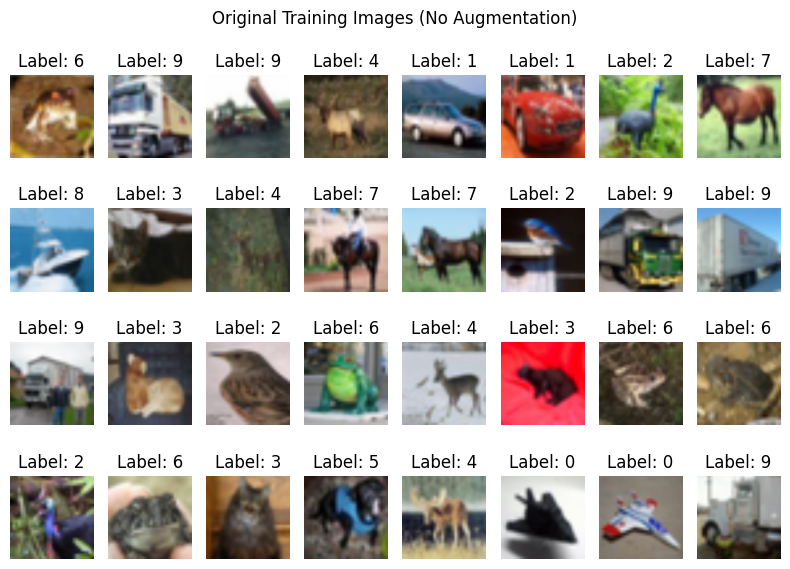

In [9]:
# Display original images (no augmentation)
num_ims = 32
print("Displaying Original Training Images (No Augmentation)")
plot_multiple_images(train_loader_no_aug, num_ims, "Original Training Images (No Augmentation)")


Displaying Training Images (With Augmentation)


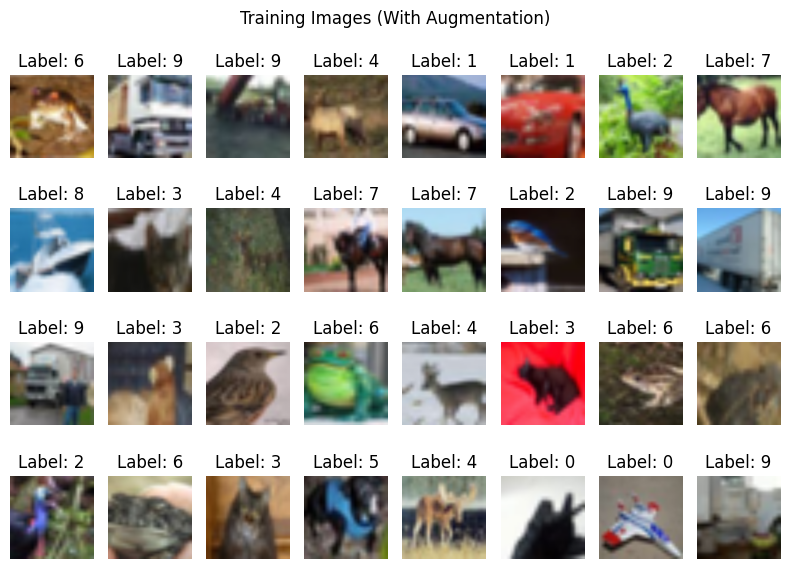

In [10]:
# Display augmented images from the augmented loader
# train_loader_aug = DataLoader(train_set, batch_size=32, shuffle=False)

print("Displaying Training Images (With Augmentation)")
plot_multiple_images(train_loader, num_ims, "Training Images (With Augmentation)")


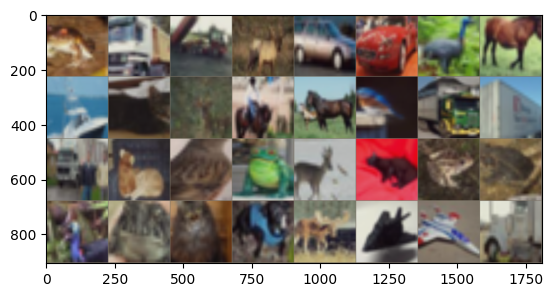

labesls are: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9,
        6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6,
        1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1,
        2, 2, 9, 2, 6, 6, 1, 9])


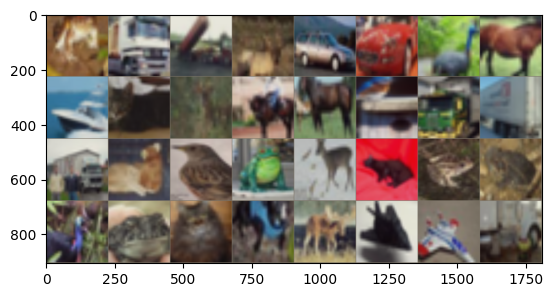

In [ ]:


# show some training images with shuffle=False and labels

# show them again to check the augmentation

# create train loader with shuffle true


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [8]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    if train_mode:
        model.train()
    else:
        model.eval()
    
    batch_losses = []
    for _, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        if train_mode:
            # Backward pass and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        batch_losses.append(loss.item())
    
    return batch_losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    model.to(device) 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        print(f"### Epoch {epoch+1}/{epochs} ###")
        
        # Training Phase
        train_epoch_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        avg_train_loss = sum(train_epoch_losses) / len(train_epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"Training Loss: {avg_train_loss:.3f} | Training Accuracy: {get_acc(model, train_loader):.2f}")

        
        # Validation Phase
        val_epoch_losses = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.3f} | Validation Accuracy: {get_acc(model, val_loader):.2f}")
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")
    
    print("Training complete.")
    return train_losses, val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()  
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predicted class
            predicted = torch.argmax(outputs, 1)
            
            total += labels.size(0) # batch_size
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    # print(f"Validation Accuracy: {accuracy:.2f}%")
    return accuracy


def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses with optional smoothing for training losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    number_of_epochs = len(val_losses)
    epochs = range(1, len(train_losses) + 1)
    val_epochs = np.linspace(1, len(train_losses), number_of_epochs)
    
    # Smooth training losses using convolution
    if c_window > 1 and len(train_losses) >= c_window:
        kernel = np.ones(c_window) / c_window
        smoothed_train_losses = np.convolve(np.array(train_losses), kernel, mode='valid')
        smoothed_epochs = range(1, len(smoothed_train_losses) + 1)
    else:
        smoothed_train_losses = train_losses
        smoothed_epochs = epochs

    # Plot raw training loss
    plt.plot(epochs, train_losses, label='Training Loss (Raw)', alpha=0.3, color='blue')
    
    # Plot smoothed training loss
    # plt.plot(smoothed_epochs, smoothed_train_losses, label='Training Loss (Smoothed)', color='blue')
    
    # Plot validation loss
    plt.plot(val_epochs, val_losses, label='Validation Loss', marker='o', markersize=6, color='red')
    
    # Plot labels
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
print(device)

cuda


Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [10]:
def conv_bn(inp, oup, stride):
    """
    Standard Convolution followed by Batch Normalization and ReLU activation.
    
    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the convolution.
    
    Returns:
        nn.Sequential: Sequential layer with Conv2D, BatchNorm2D, and ReLU.
    """
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )
def conv_dw(inp, oup, stride):
    """
    Depthwise Separable Convolution: Depthwise Conv + Pointwise Conv, each followed by BN and ReLU.
    
    Args:
        inp (int): Number of input channels.
        oup (int): Number of output channels.
        stride (int): Stride for the depthwise convolution.
    
    Returns:
        nn.Sequential: Sequential layer with Depthwise Conv, BN, ReLU, Pointwise Conv, BN, ReLU.
    """
    return nn.Sequential(
        # Depthwise Convolution 
        # Depthwise Convolution Doesn't Change the Number of Channels
        # input channel = output channel
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),
        
        # Pointwise Convolution
        # stride is constant and equals 1
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.

## Depthwise Separable Convolutions: Parameter Reduction and Speed Improvement

Depthwise Separable Convolutions are an optimized version of standard convolutions, commonly used in lightweight neural network architectures like MobileNet. They break down the convolution operation into two distinct steps:

1. **Depthwise Convolution:** Applies a single filter to each input channel independently.  
2. **Pointwise Convolution:** Uses a \(1 \times 1\) convolution to combine the outputs from the depthwise convolution.


### 1. Parameter Comparison

In a standard convolution, every output channel is created using a set of filters applied across all input channels. This approach results in a large number of parameters and significant computational cost.

In contrast, depthwise separable convolutions split the process into two stages. The depthwise convolution applies a single filter per input channel, significantly reducing the number of parameters. Then, the pointwise convolution combines these filtered outputs using a lightweight operation.

This separation reduces the total number of parameters drastically because it avoids the heavy cross-channel computations of standard convolutions. The reduction in parameters translates directly into less memory usage and lower computational cost.


### 2. Why is it Faster?

- **Fewer Parameters:** The reduction in the number of parameters reduces both the memory requirements and the number of mathematical operations.  
- **Simpler Computations:** Depthwise and pointwise convolutions are computationally less intensive compared to standard convolutions.  
- **Better Memory Efficiency:** With fewer parameters, the model can make better use of memory and caching, leading to faster execution on both CPUs and GPUs.  

These factors together make depthwise separable convolutions ideal for real-time applications and resource-constrained environments like mobile or embedded devices.


### 3. Key Takeaways

- Depth-wise Convolution: Applies a single convolutional filter per input channel. Each channel is processed independently.
- Point-wise Convolution (1x1 Convolution): Combines the outputs from the depth-wise convolution across all channels using a 1x1 convolution.
- No mixing of information across channels in this method. Each channel is treated independently.
- In standard convolution, Each filter operates across all input channels simultaneously and outputs a single channel.


### 4. Comparison of number of parameters 

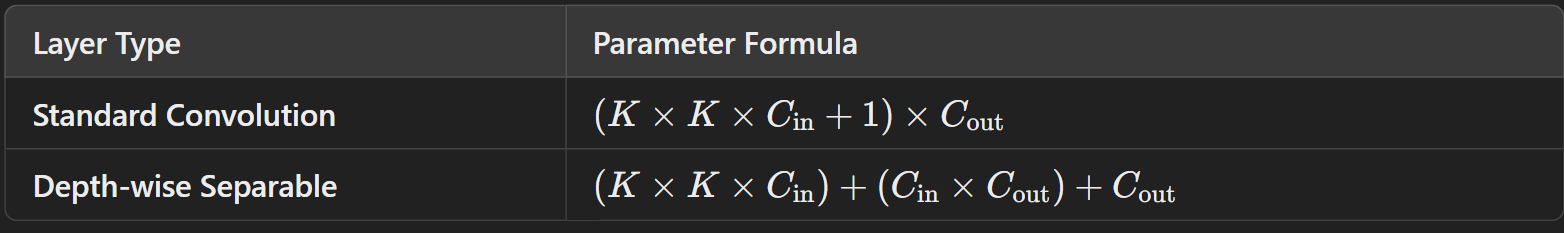
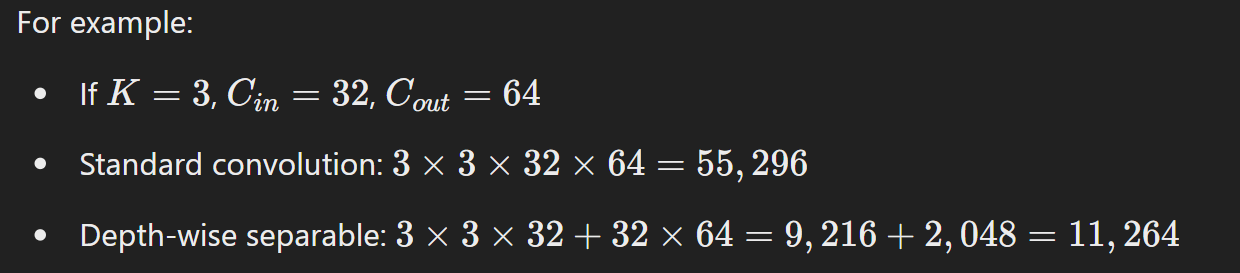

__In above example bias is not considered.__


Now please create your model.

In [11]:
class MobileNet(nn.Module):
    def __init__(self, n_class=10):
        """
        MobileNet Architecture.
        Args:
            n_class (int): Number of output classes.
        """
        super(MobileNet, self).__init__()
        
        self.model = nn.Sequential(
            # Initial Standard Convolution
            conv_bn(3, 32, stride=2),  # Input: 224x224x3 -> Output: 112x112x32
            
            # Depthwise Separable Convolution Blocks
            conv_dw(32, 64, stride=1),  # 112x112x32 -> 112x112x64
            conv_dw(64, 128, stride=2), # 112x112x64 -> 56x56x128
            conv_dw(128, 128, stride=1), # 56x56x128 -> 56x56x128
            conv_dw(128, 256, stride=2), # 56x56x128 -> 28x28x256
            conv_dw(256, 256, stride=1), # 28x28x256 -> 28x28x256
            conv_dw(256, 512, stride=2), # 28x28x256 -> 14x14x512
            
            # 5x Depthwise Separable Blocks with same output. 14x14x512 -> 14x14x512
            conv_dw(512, 512, stride=1), 
            conv_dw(512, 512, stride=1), 
            conv_dw(512, 512, stride=1), 
            conv_dw(512, 512, stride=1), 
            conv_dw(512, 512, stride=1), 

            conv_dw(512, 1024, stride=2), # 14x14x512 -> 7x7x1024
            conv_dw(1024, 1024, stride=1), # 7x7x1024 -> 7x7x1024
            
            # Global Average Pooling
            nn.AdaptiveAvgPool2d(1) # 7x7x1024 -> 1x1x1024
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(1024, n_class)
    
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten before FC (batch_size, num_featuers)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

Get some metrics and plot your losses.

In [22]:
epochs = 10
lr = 1e-3
mobile_net_model = MobileNet(n_class = 10).to(device)
start = time.time()
train_losses, validation_losses = train(train_loader, val_loader, mobile_net_model, epochs, lr)
end = time.time()
print("Process training time: {:0.3f} s".format(end - start))

### Epoch 1/10 ###
Training Loss: 1.649 | Training Accuracy: 48.24
Validation Loss: 1.450 | Validation Accuracy: 47.28
Model saved to ./model.pt
### Epoch 2/10 ###
Training Loss: 1.310 | Training Accuracy: 55.03
Validation Loss: 1.253 | Validation Accuracy: 57.38
Model saved to ./model.pt
### Epoch 3/10 ###
Training Loss: 1.111 | Training Accuracy: 64.70
Validation Loss: 0.977 | Validation Accuracy: 65.48
Model saved to ./model.pt
### Epoch 4/10 ###
Training Loss: 0.955 | Training Accuracy: 68.88
Validation Loss: 0.842 | Validation Accuracy: 70.76
Model saved to ./model.pt
### Epoch 5/10 ###
Training Loss: 0.848 | Training Accuracy: 72.04
Validation Loss: 0.777 | Validation Accuracy: 73.60
Model saved to ./model.pt
### Epoch 6/10 ###
Training Loss: 0.755 | Training Accuracy: 73.72
Validation Loss: 0.745 | Validation Accuracy: 74.52
Model saved to ./model.pt
### Epoch 7/10 ###
Training Loss: 0.696 | Training Accuracy: 78.89
Validation Loss: 0.643 | Validation Accuracy: 78.40
Model saved

---

Batch_size=64, epochs=10, lr=0.001
Val accuracy = 80.44
Process validation time: 9.4119 s


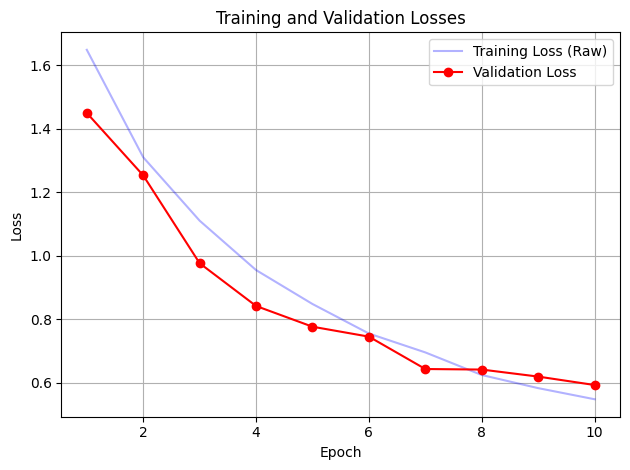

In [23]:
start = time.time()
val_acc = get_acc(mobile_net_model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(val_images.shape[0], epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(train_losses, validation_losses,1)

In [24]:
test_acc = get_acc(mobile_net_model, test_loader)
print(f"Test accuracy is: {test_acc:.2f}")

Test accuracy is: 79.96


### Question
The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.

### Answer 
As we have seen before the number of parametrs to be caclulated in Standard Convolution architucture is signifiacntly higher than Depthwise seperable Convulution architcture.

#### Number of learnable parameters for Standard convolution layer :
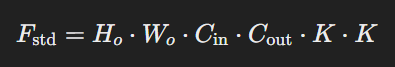

#### Number of learnable parameters for Depthwise seperable convolution layer :

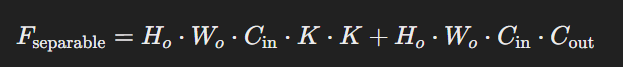

- The first Term is for Depth-wise convolution where Cin=Cout.
- The second term stands for Point-wise convolution. (weighted summation of channel values at each spatial location)

We define a ratio of **speed up** to caclulate the speed we are gaining.

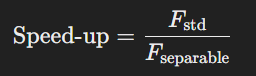

- Substituting the formulas we get :

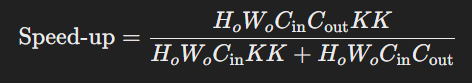

- Canceling out H, W and Cin

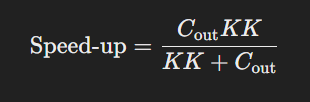

- Typical K values are 3. (3x3 filters)
- substituting 3 for K.

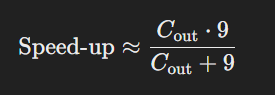


- For large values of Cout which is the case almost all of the times we get the above approximation and we can neglect the `+9` in denominator. and we can say: 

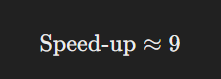


## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [13]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

#### 2 epochs

In [14]:

n_class = 10 
epochs = 2
lr = 1e-3

standard_cnn = NormalCNN(n_class=n_class).to(device)
start = time.time()
standard_cnn_train_losses, standard_cnn_validation_losses = train(train_loader,val_loader,standard_cnn,epochs,lr
)
end = time.time()
print("Process trainning time: {:0.4f} s".format(end - start))


### Epoch 1/2 ###
Training Loss: 1.957 | Training Accuracy: 31.20


c:\ProgramData\anaconda3\envs\deeplearning\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation Loss: 1.775 | Validation Accuracy: 33.12
Model saved to ./model.pt
### Epoch 2/2 ###
Training Loss: 1.738 | Training Accuracy: 36.65
Validation Loss: 1.741 | Validation Accuracy: 38.46
Model saved to ./model.pt
Training complete.
Process trainning time: 463.0738 s


#### 10 epochs

In [15]:
n_class = 10 
epochs = 10
lr = 1e-3

standard_cnn = NormalCNN(n_class=n_class).to(device)
start = time.time()
standard_cnn_train_losses, standard_cnn_validation_losses = train(train_loader,val_loader,standard_cnn,epochs,lr
)
end = time.time()
print("Process trainning time: {:0.4f} s".format(end - start))


### Epoch 1/10 ###
Training Loss: 1.943 | Training Accuracy: 27.60
Validation Loss: 2.278 | Validation Accuracy: 27.78
Model saved to ./model.pt
### Epoch 2/10 ###
Training Loss: 1.733 | Training Accuracy: 37.30
Validation Loss: 1.730 | Validation Accuracy: 36.72
Model saved to ./model.pt
### Epoch 3/10 ###
Training Loss: 1.603 | Training Accuracy: 43.06
Validation Loss: 1.517 | Validation Accuracy: 43.04
Model saved to ./model.pt
### Epoch 4/10 ###
Training Loss: 1.441 | Training Accuracy: 48.16
Validation Loss: 1.429 | Validation Accuracy: 48.10
Model saved to ./model.pt
### Epoch 5/10 ###
Training Loss: 1.290 | Training Accuracy: 54.94
Validation Loss: 1.166 | Validation Accuracy: 57.36
Model saved to ./model.pt
### Epoch 6/10 ###
Training Loss: 1.178 | Training Accuracy: 53.56
Validation Loss: 1.254 | Validation Accuracy: 56.82
### Epoch 7/10 ###
Training Loss: 1.063 | Training Accuracy: 63.24
Validation Loss: 0.949 | Validation Accuracy: 66.72
Model saved to ./model.pt
### Epoch 8

Batch_size=64, epochs=10, lr=0.001
Val accuracy = 72.38
Process validation time: 13.8043 s


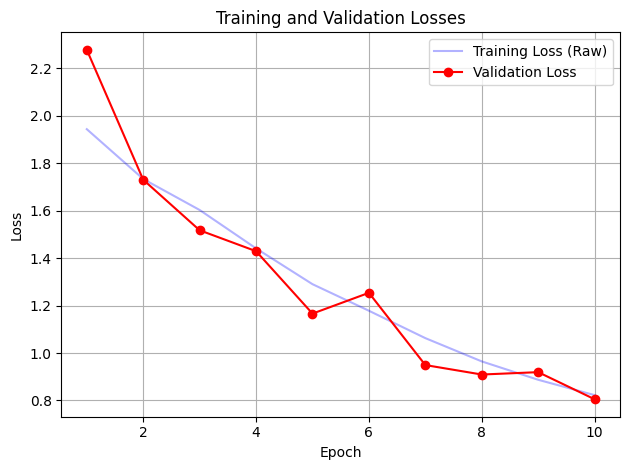

In [16]:
start = time.time()
val_acc = get_acc(standard_cnn, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(val_images.shape[0], epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(standard_cnn_train_losses, standard_cnn_validation_losses)

In [17]:
test_acc = get_acc(standard_cnn, test_loader)
print(f"Test accuracy after 10 epochs for Standard Cnn is: {test_acc:.2f}")

Test accuracy after 10 epochs for Standard Cnn is: 72.30


In [25]:
test_acc = get_acc(mobile_net_model, test_loader)
print(f"Test accuracy after 10 epochs for MobileNet is: {test_acc:.2f}")

Test accuracy after 10 epochs for MobileNet is: 79.96


### Question
Compare speed of learning and validating in normal CNN vs MobileNet

### Answer


#### Training Time Comparison for 10 epochs each 
- MobileNet: 1585 seconds
- Standard CNN: 2415 seconds

#### Inference Time Comparison each on size 5000 test dataset.
- MobileNet: 9.4 seconds
- Standard CNN: 13.8 seconds

* Also the interesting fact is that the Test score of MobileNet is better.
    - MobileNet: 79.96%
    - Standard CNN: 72.30%

---

| **Metric**       | **MobileNet** | **Standard CNN** |
|-------------------|--------------:|-----------------:|
| **Training Time (10 Epochs on 25k Train Samples)** | 1585 seconds | 2415 seconds |
| **Inference Time (5000 Test Samples)** | 9.4 seconds | 13.8 seconds |
| **Test Accuracy** | 79.96% | 72.30% |
| **Number of Trainable Parameters** | 3,217,226 | 28,279,338 |


MobileNet demonstrates **superior efficiency** in terms of **training time**, **inference time**, and **parameter efficiency**, while also achieving a **higher test accuracy** compared to a standard CNN.


In [26]:
def count_parameters(model):
    """
    Args:
        model (nn.Module)
    Returns:
        int: Total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(mobile_net_model)
print(f"Number of Trainable Parameters MobileNet v1: {num_params}")
num_params = count_parameters(standard_cnn)
print(f"Number of  Trainable Parameters Standard CNN: {num_params}")

Number of Trainable Parameters MobileNet v1: 3217226
Number of  Trainable Parameters Standard CNN: 28279338


In [ ]:
# TODO: compare number of parameters in these two models

Total number of normal CNN parameters: 28279338
Total number of MobileNet parameters: 3217226


### Question
In the above implementation of mobile net V1 we dont consider α and ρ. but in this section we want to explore it theoritically. before that introducing a comprehensive guide about how we can modify our model to consider this hyperparameters. 


### Answer

In the original MobileNetV1 [architecture](https://arxiv.org/pdf/1704.04861), the width multiplier (α) and the resolution multiplier (ρ) are introduced as hyperparameters to create a trade-off between accuracy and computational efficiency. These two parameters allow us to adjust the model size and input resolution, making MobileNet adaptable for different deployment scenarios, especially on devices with limited resources.

- **Alpha** : The width multiplier (α) is used to scale the number of channels in each convolutional layer. Its value  lies in the range (0 < α ≤ 1). A smaller α reduces the number of channels in each layer

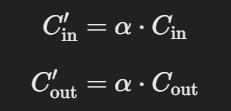

- **Rho**: The resolution multiplier (ρ) is used to scale the input image resolution. Its value also  lies in the range (0 < ρ ≤ 1).
A smaller ρ reduces Spatial dimensions (Height × Width) of the image.

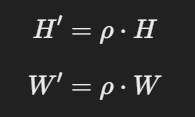

- #### Alpha impact on a convolution layers :

 The total number of parameters in a convolutional layer is (learnable kernel parameters):

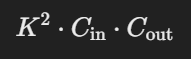

- After applying α:

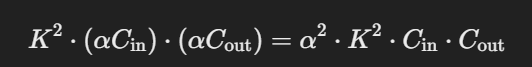

- #### Alpha and Rho impact on Computation Cost (FLOPs):

Before applying α & ρ: 

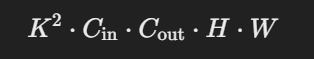

After applying α & ρ: 

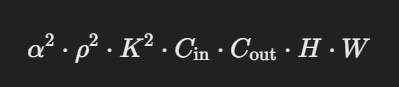

This indicates that both α and ρ reduce computational cost **quadratically**.

**These parameters can be adjusted to achieve a balance between accuracy and efficiency based on hardware limitations.**


---








### Question
Explain how α hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.


### Answer

As explaied above, The α hyperparameter (also known as the width multiplier) in MobileNet is used to scale the width (number of channels) of a neural network uniformly across all layers. It reduces the number of input and output channels, which directly impacts the number of parameters in each layer.

We know the number of parametrs in a standard convolutional layer is:

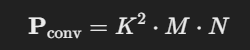

where M and N are input and output channel (dims) and K is the size of filter.

As we saw above after applying α we have:

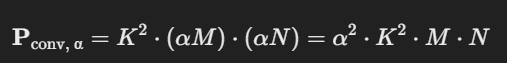

We know for Depthwise seperable convolution the parametrs are splitted to **Depthwise convolution** and **Pointwise convolution** which are `K^2.M` and `M.N` in order.


Writing the formula and simplying it gives us:

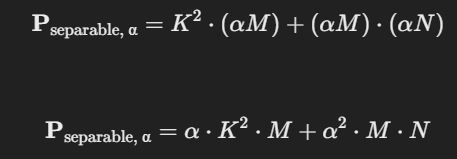

This formula represents the theoretical effect of the width multiplier α on the total number of parameters in a depthwise separable convolutional layer.

which results in:

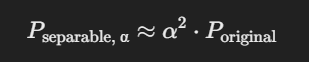

In above implementatio  we have not used α. (α=1)


---

### Question
Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

### Answer

The resolution multiplier (ρ) is a hyperparameter in MobileNetV1 used to scale the input image resolution and consequently reduce the spatial dimensions of feature maps across all layers.

- ρ scales the input image resolution before it is fed into the convolutional layers.

For example we can reduce the input size from `224x224` to `112*112` with `ρ=0.5`.

** As we see above it can drastically reduce the computional cost and hence making the model such faster. **

- For example if `ρ=0.5` then the cost decreases (0.5)^2 which means 75% reduction.
- We should keep in mind that ρ does not reduce the number of learnable paramers in each layer. (as described above this α does that.)


---

### Question
Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal? 

### Answer

It’s true that modern GPUs are incredibly powerful and capable of handling millions, even billions, of parameters. However, the number of parameters in a neural network still matters for several critical reasons, especially in practical applications.

- ##### Model Size and Storage Constraints:
    - Large models with millions or billions of parameters require significant storage space.
    - Deploying these models on edge devices, mobile phones, or embedded systems with limited memory is challenging.
    - Smaller models are easier to transfer over networks, which is crucial for real-time applications or environments with low bandwidth.
- ##### Computational Cost During Inference:
    - Inference, especially in real-time systems, must be fast and efficient.
    - A model with fewer parameters requires fewer computations, resulting in faster inference and reduced latency.
    - On devices with limited computational resources (e.g., IoT devices, mobile phones), smaller models are more feasible.
- #####  Training Time and Costs:
    - Training large models requires more computational power and time, which translates to higher costs, both in terms of hardware usage and energy consumption.
    - Smaller models are not only faster to train but also cheaper, making them more accessible for researchers and smaller companies.
- #####  Overfitting on Small Datasets:
    - Models with too many parameters are more prone to overfitting, especially when the dataset is small.
    - Overfitting means the model memorizes the training data instead of generalizing to unseen data.
    - Regularization techniques can help, but reducing unnecessary parameters is often more effective.
- ##### Environmental Impact:
    - Training large neural networks consumes vast amounts of electricity, contributing significantly to carbon emissions.
    - Efficient models help reduce energy usage, aligning with sustainable AI practices and minimizing the environmental footprint of large-scale AI deployments.
- #####  Scalability Across Devices: 
    - Not all devices have the same computational capabilities. A model that runs efficiently on a high-end GPU may not perform well on a mobile CPU or embedded hardware.
    - Smaller models with fewer parameters are easier to scale across different platforms, from cloud servers to mobile devices.

- Above we have listed some key considerations regarding size of NN models.
- while GPUs and modern hardware significantly boost computational power, the number of parameters remains a crucial consideration. Smaller models ensure better scalability, lower energy consumption, faster inference, and broader accessibility across diverse devices and applications. Optimizing model size without sacrificing performance is key to building efficient, sustainable, and deployable neural networks.

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.

These architectures (Mobilenet family) are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

### Speciall thanks to [Amirmahdi Meighani](https://www.linkedin.com/in/amirmm03/) (notebook main author) 

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017
